# Deposition in a single step

## Observations

In this notebook a few observations and rough and simple analysis will be made on the simulation of the deposition of nanoparticles in a single step. Here a total of $N_{Nps}$ nanoparticles are inserted at once in a region above a gold substrate.

The data from the simulation will be mostly analysed using the ovito python package imported below

In [1]:
from ovito.io import import_file
import numpy as np
import matplotlib.pyplot as plt

C:\Users\becat\anaconda3\lib\site-packages\ovito\_extensions\averaging.py:2: UserWarning: Did you accidentally install the OVITO package from the PyPI repository in an Anaconda/Miniconda Python interpreter using the 'pip' command? This will likely lead to conflicts with existing libraries in the Anaconda environment, and import of the OVITO module may fail with an error related to the Qt framework. To fix this, please uninstall the ovito pip package by running 'pip uninstall -y ovito PySide6' and then install the OVITO Anaconda package provided by OVITO GmbH. Visit https://docs.ovito.org/python/introduction/installation.html for further instructions. If you would rather like to ignore this warning message, add the following code to the top of your Python script:

  import warnings
  warnings.filterwarnings('ignore', message='.*OVITO.*PyPI')

  import ovito._extensions.pyscript


A function to calculate uncertainty with data blocking is defined below

In [2]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

First the dump from the simulation is imported into the ovito pipeline

In [29]:
pipeline = import_file("./dump/dump.lattice")

### Thickness

A first simple analysis is made on the thickness of the film. First an empty list is created

In [53]:
thick = np.zeros(pipeline.source.num_frames)

then a loop over all frames in the dump calculates the maximum thickness as $z_{max} - z_{min}$

In [31]:
for i in range(pipeline.source.num_frames):
    data = pipeline.compute(i)
    thick[i] = max(data.particles['Position'][:,2]) - min(data.particles['Position'][:,2])


the resulting thickenss as a function of the timestep is then converted to nm and plotted

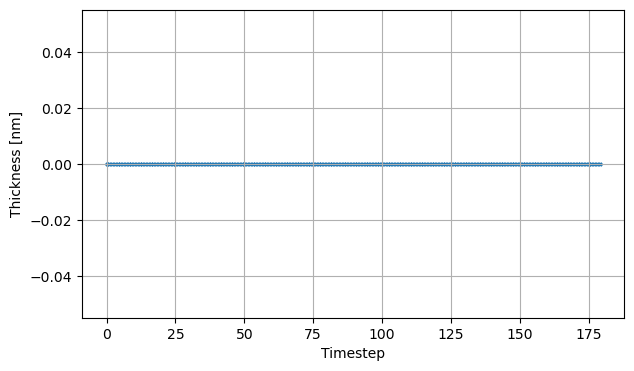

In [56]:
t = np.arange(pipeline.source.num_frames)
plt.figure(figsize=(7,4))
plt.scatter(t[:],thick[:] / 10, s = 5, marker = 'x')
plt.xlabel("Timestep")
plt.ylabel("Thickness [nm]")
plt.grid()


***
An analysis of the data is done using data blocking below:

In [33]:
N = 20
L = pipeline.source.num_frames // N
ave = np.zeros(N)
av2 = np.zeros(N)

for i in range(N):
    sum1 = 0
    sum2 = 0 #PROVA per far vedere come si può sbagliare ad interpretare il calcolo di A_i^2
    for j in range(L):
        k = j+i*L
        sum1 += thick[k]

    ave[i] = sum1/L     # r_i 
    #av2[i] = sum2/L     # (r_i)^2 #PROVA
    av2[i] = (ave[i])**2 # (r_i)^2 

thick_prog = np.zeros(N)
thick2_prog = np.zeros(N)
thickerr_prog = np.zeros(N)

for i in range(N):
    for j in range(i+1):
        thick_prog[i] += ave[j] # SUM_{j=0,i} r_j
        thick2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    thick_prog[i]/=(i+1) # Cumulative average
    thick2_prog[i]/=(i+1) # Cumulative square average
    thickerr_prog[i] = error(thick_prog,thick2_prog,i) # Statistical uncertainty
    #av2[i] = sum2/L     # (r_i)^2 #PROVA
    av2[i] = (ave[i])**2 # (r_i)^2 

The data is then plotted using errorbars

Text(0.5, 0, 'Blocks')

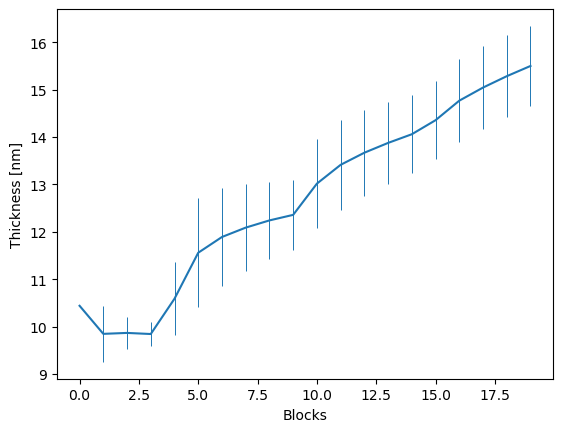

In [34]:
x = np.arange(N)
plt.errorbar(x,thick_prog / 10,yerr=thickerr_prog / 10, elinewidth = 0.7)
plt.ylabel("Thickness [nm]")
plt.xlabel("Blocks")

### Regions

A simple consideration of the regions (empty and filled) is studied using a Surface Mesh modifier. First the required dunctions are imported

In [35]:
from ovito.modifiers import TimeSeriesModifier, ComputePropertyModifier, ConstructSurfaceModifier

then a simple modifier meant to adapt the simulation cell to the particles so that empty space above and below the film won't be considered in the analysis is implemented (function from https://www.ovito.org/docs/current/python/introduction/examples/modifiers/shrink_wrap_box.html)

In [36]:
from ovito.data import SimulationCell, DataCollection

def shrink_modify(frame: int, data: DataCollection):

    # There's nothing we can do if there are no input particles. 
    if not data.particles or data.particles.count == 0: return

    # Compute min/max range of particle coordinates.
    coords_min = numpy.amin(data.particles.positions, axis=0)
    coords_max = numpy.amax(data.particles.positions, axis=0)

    # Build the new 3x4 cell matrix:
    #   (x_max-x_min  0            0            x_min)
    #   (0            y_max-y_min  0            y_min)
    #   (0            0            z_max-z_min  z_min)
    matrix = numpy.empty((3,4))
    matrix[:,:3] = numpy.diag(coords_max - coords_min)
    matrix[:, 3] = coords_min

    # Assign the cell matrix - or create whole new SimulationCell object in 
    # the DataCollection if there isn't one already.
    data.create_cell(matrix, (False, False, False))

then, after appending the shrink_modify modifier to the pipeline, a ConstructSurfaceModifier is appended as well. This modifier builds a surface mesh to give a solid volume to collections of particles, with pair of particles between 2.9 Angstrom of each other being considered part of the same volume. The identify_regions parameter is used to identify empty, filled and void regions. After this modifier is appended a Time Series modifier is appended as well, this will allow to follow the analysis of the Construct Surface Modifier with increasing timestep.  

In [37]:
import numpy
pipeline.modifiers.append(shrink_modify)

pipeline.modifiers.append(ConstructSurfaceModifier(radius = 2.9, identify_regions = True))
pipeline.modifiers.append(TimeSeriesModifier(operate_on = 'ConstructSurfaceMesh.filled_fraction'))

data = pipeline.compute()
series = data.tables['time-series']

The resulting analysis of the filled fraction is the plotted against the timestep

Text(0.5, 1.0, 'Filled Fraction')

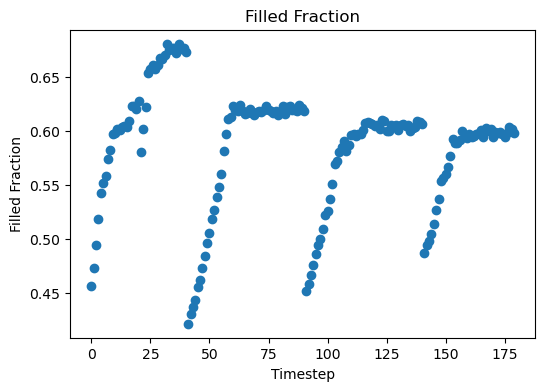

In [38]:
plt.figure(figsize = (6,4))
plt.scatter(series.x[:],series.y[:])
plt.ylabel("Filled Fraction")
plt.xlabel("Timestep")
plt.title("Filled Fraction")

Then datablocking is used to get an estimate of the average and its uncertainty

In [39]:
N = 20
L = pipeline.source.num_frames // N
ave = np.zeros(N)
av2 = np.zeros(N)
for i in range(N):
    sum1 = 0
    sum2 = 0 #PROVA per far vedere come si può sbagliare ad interpretare il calcolo di A_i^2
    for j in range(L):
        k = j+i*L
        sum1 += series.y[:][k]

    ave[i] = sum1/L     # r_i 
    #av2[i] = sum2/L     # (r_i)^2 #PROVA
    av2[i] = (ave[i])**2 # (r_i)^2 

fill_prog = np.zeros(N)
fill2_prog = np.zeros(N)
fillerr_prog = np.zeros(N)

for i in range(N):
    for j in range(i+1):
        fill_prog[i] += ave[j] # SUM_{j=0,i} r_j
        fill2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    fill_prog[i]/=(i+1) # Cumulative average
    fill2_prog[i]/=(i+1) # Cumulative square average
    fillerr_prog[i] = error(fill_prog,fill2_prog,i) # Statistical uncertainty

The resulting data is plotted using errorbars

Text(0.5, 0, 'Blocks')

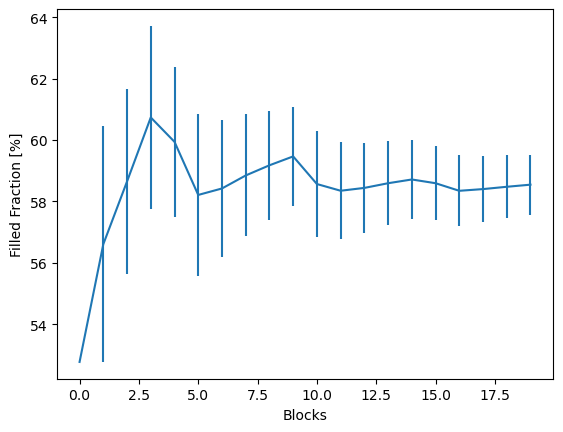

In [40]:
x = np.arange(N)

plt.errorbar(x,fill_prog * 100,yerr=fillerr_prog * 100)
plt.ylabel("Filled Fraction [%]")
plt.xlabel("Blocks")

***
A comparison between the thickness and the filled fraction shows an inverse relation for a small number of nanoparticles deposited

Text(0.5, 1.0, 'Filled Fraction vs Block')

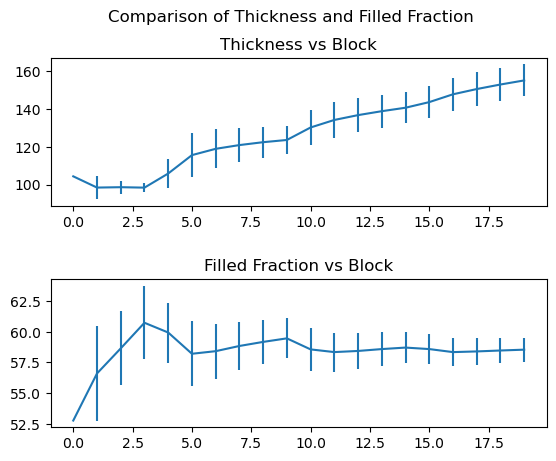

In [41]:
fig, axs = plt.subplots(2)
fig.suptitle('Comparison of Thickness and Filled Fraction')
axs[0].errorbar(x,thick_prog,yerr=thickerr_prog)
axs[0].set_title("Thickness vs Block")
fig.subplots_adjust(hspace=0.5)

axs[1].errorbar(x,fill_prog * 100,yerr=fillerr_prog * 100)
axs[1].set_title("Filled Fraction vs Block")
